In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import xgboost as xgb

In [3]:
xgb.__version__

'0.90'

In [4]:
DATA_DIR_PATH = os.path.join('/content/drive/My Drive/kikagaku/novelfind', 'data')

def laod_data(file_name):
  file_path = os.path.join(DATA_DIR_PATH, file_name)
  return pd.read_csv(file_path, header=0)

In [106]:
df_train = laod_data('bookmark_train_data.csv')
print(len(df_train))
df_train.head(3)

199


,ncode,title,category,bookmark_cat,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,talk_char_count_avg,new_line_count_rate_avg,talk_char_count_rate_avg,wc_sum_その他,wc_sum_フィラー,wc_sum_副詞,wc_sum_助動詞,wc_sum_助詞,wc_sum_動詞,wc_sum_名詞,wc_sum_形容詞,wc_sum_感動詞,wc_sum_接続詞,wc_sum_接頭詞,wc_sum_記号,wc_sum_連体詞,wc_rate_その他,wc_rate_フィラー,wc_rate_副詞,wc_rate_助動詞,wc_rate_助詞,wc_rate_動詞,wc_rate_名詞,wc_rate_形容詞,wc_rate_感動詞,wc_rate_接続詞,wc_rate_接頭詞,...,kw_テンプレ,kw_勘違い,kw_ほのぼの,kw_貴族,kw_ギルド,kw_コメディ,kw_異世界,kw_エルフ,kw_ファンタジー,kw_オリジナル戦記,kw_チート,kw_R15,kw_ダンジョン,kw_ステータス,kw_料理,kw_ラブコメ,kw_中世,kw_異世界召喚,kw_剣と魔法,kw_学園,kw_異能力バトル,kw_勇者,kw_冒険,kw_主人公最強,kw_転生,kw_シリアス,kw_異世界転移,kw_追放,kw_ざまぁ,kw_西洋,kw_最強,kw_スキル,kw_魔法,kw_異世界転生,kw_ご都合主義,kw_ハッピーエンド,kw_書籍化,kw_おっさん,kw_残酷な描写あり,rating
0,n4366gd,雷帝の軌跡 ～俺だけ使える【雷魔術】で最強の魔術師を目指します～,ハイファンタジー〔ファンタジー〕,1,1.586338e+09,1.593468e+09,92340,3840,28950,0.041585,0.313515,3078.0,128.0,965.0,0.041585,0.313515,0,60,2250,5040,14160,13470,13410,810,360,420,360,8580,660,0.0,0.001007,0.037764,0.084592,0.237664,0.226083,0.225076,0.013595,0.006042,0.007049,0.006042,...,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,3.0
1,n7336gg,星斬りの剣士,ハイファンタジー〔ファンタジー〕,1,1.590714e+09,1.593338e+09,77880,4140,4950,0.053159,0.063559,2596.0,138.0,165.0,0.053159,0.063559,0,90,1770,4590,12390,12360,11280,930,60,540,60,7170,690,0.0,0.001733,0.034084,0.088388,0.238590,0.238013,0.217215,0.017909,0.001155,0.010399,0.001155,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.0
2,n9677fw,落ちこぼれ国を出る〜実は世界で４人目の付与術師だった件について〜,ハイファンタジー〔ファンタジー〕,1,1.575176e+09,1.593429e+09,59880,3090,10230,0.051603,0.170842,1996.0,103.0,341.0,0.051603,0.170842,0,0,1620,2610,8910,6570,10560,540,0,210,330,5490,210,0.0,0.000000,0.043725,0.070445,0.240486,0.177328,0.285020,0.014575,0.000000,0.005668,0.008907,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,3.0


In [107]:
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
cat_le.fit(df_train['category'])

WORD_CLASSE_LABELS = ['その他', 'フィラー', '副詞', '助動詞', '助詞',
                     '動詞', '名詞', '形容詞', '感動詞', '接続詞',
                     '接頭詞', '記号', '連体詞',]
new_wc_columns = {}

for (i, name) in enumerate(WORD_CLASSE_LABELS):
    new_wc_columns['wc_sum_{}'.format(name)] = 'wc_sum_{}'.format(i)
    new_wc_columns['wc_rate_{}'.format(name)] = 'wc_rate_{}'.format(i)


def data_preprocess(df):
    new_df = df.drop(['ncode', 'title', 'bookmark_cat'], axis=1)

    new_df['category'] = cat_le.transform(new_df['category'])

    new_df['rating'] = new_df['rating'] * 10
    new_df = new_df.astype({'rating': 'int32'})

    #wc_columns = [col for col in new_df.columns if col.find('wc_') != -1]
    #new_df = new_df.drop(wc_columns, axis=1)
    #wc_columns = [col for col in new_df.columns if col.find('wc_sum_') != -1]
    #new_df = new_df.drop(wc_columns, axis=1)
    new_df = new_df.rename(columns=new_wc_columns)

    kw_columns = [col for col in new_df.columns if col.find('kw_') != -1]
    new_df = new_df.drop(kw_columns, axis=1)

    return new_df

In [108]:
df_train.keys()

Index(['ncode', 'title', 'category', 'bookmark_cat', 'created_at',
       'updated_at', 'char_count_sum', 'new_line_count_sum',
       'talk_char_count_sum', 'new_line_count_rate_sum',
       'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg',
       'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_sum_その他', 'wc_sum_フィラー', 'wc_sum_副詞',
       'wc_sum_助動詞', 'wc_sum_助詞', 'wc_sum_動詞', 'wc_sum_名詞', 'wc_sum_形容詞',
       'wc_sum_感動詞', 'wc_sum_接続詞', 'wc_sum_接頭詞', 'wc_sum_記号', 'wc_sum_連体詞',
       'wc_rate_その他', 'wc_rate_フィラー', 'wc_rate_副詞', 'wc_rate_助動詞',
       'wc_rate_助詞', 'wc_rate_動詞', 'wc_rate_名詞', 'wc_rate_形容詞', 'wc_rate_感動詞',
       'wc_rate_接続詞', 'wc_rate_接頭詞', 'wc_rate_記号', 'wc_rate_連体詞', 'kw_冒険者',
       'kw_魔王', 'kw_日常', 'kw_成り上がり', 'kw_内政', 'kw_恋愛', 'kw_無双', 'kw_青春',
       'kw_ハーレム', 'kw_男主人公', 'kw_奴隷', 'kw_テンプレ', 'kw_勘違い', 'kw_ほのぼの', 'kw_貴族',
       'kw_ギルド', 'kw_コメディ', 'kw_異世界', 'kw_エルフ', 'kw_ファンタジー', 'kw_オリジナル戦記',
       

In [109]:
df_train2 = data_preprocess(df_train)
df_train2.head(3)

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,talk_char_count_avg,new_line_count_rate_avg,talk_char_count_rate_avg,wc_sum_0,wc_sum_1,wc_sum_2,wc_sum_3,wc_sum_4,wc_sum_5,wc_sum_6,wc_sum_7,wc_sum_8,wc_sum_9,wc_sum_10,wc_sum_11,wc_sum_12,wc_rate_0,wc_rate_1,wc_rate_2,wc_rate_3,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,0.041585,0.313515,3078.0,128.0,965.0,0.041585,0.313515,0,60,2250,5040,14160,13470,13410,810,360,420,360,8580,660,0.0,0.001007,0.037764,0.084592,0.237664,0.226083,0.225076,0.013595,0.006042,0.007049,0.006042,0.144008,0.011078,30
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,0.053159,0.063559,2596.0,138.0,165.0,0.053159,0.063559,0,90,1770,4590,12390,12360,11280,930,60,540,60,7170,690,0.0,0.001733,0.034084,0.088388,0.238590,0.238013,0.217215,0.017909,0.001155,0.010399,0.001155,0.138070,0.013287,40
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,0.051603,0.170842,1996.0,103.0,341.0,0.051603,0.170842,0,0,1620,2610,8910,6570,10560,540,0,210,330,5490,210,0.0,0.000000,0.043725,0.070445,0.240486,0.177328,0.285020,0.014575,0.000000,0.005668,0.008907,0.148178,0.005668,30


In [110]:
X = df_train2.drop(['rating'], axis=1).values
y = df_train2['rating'].values
print(X.shape, y.shape)

(199, 39) (199,)


In [111]:
feature_names = df_train2.keys()[:-1]

In [112]:
print(feature_names)
print(len(feature_names))

Index(['category', 'created_at', 'updated_at', 'char_count_sum',
       'new_line_count_sum', 'talk_char_count_sum', 'new_line_count_rate_sum',
       'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg',
       'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_sum_0', 'wc_sum_1', 'wc_sum_2',
       'wc_sum_3', 'wc_sum_4', 'wc_sum_5', 'wc_sum_6', 'wc_sum_7', 'wc_sum_8',
       'wc_sum_9', 'wc_sum_10', 'wc_sum_11', 'wc_sum_12', 'wc_rate_0',
       'wc_rate_1', 'wc_rate_2', 'wc_rate_3', 'wc_rate_4', 'wc_rate_5',
       'wc_rate_6', 'wc_rate_7', 'wc_rate_8', 'wc_rate_9', 'wc_rate_10',
       'wc_rate_11', 'wc_rate_12'],
      dtype='object')
39


In [113]:
print(y)

u, counts = np.unique(y, return_counts=True)
print(len(u))
print(u)
print(counts)

[30 40 30 40 30 30 30 40 50 20 40 40 30 30 50 40 40 40 30 25 20 30 20 40
 40 40 35 30 20 20 40 30 40 20 30 20 35 20 20 30 35 35 35 10 30 45 75 60
 15 60 60 30 60 45 45 30 45 45 45 52 15 15 45 45 52 45 60 15 45 45 52 45
 45 75 45 45 52 60 52 67 60 45 45 60 52 45 52 67 60 52 10 15  5 17 15 10
 15 15 10 15 15 10  5 10 15 15 15 10 10 10 15 15 10 15 10 10 15  5  5  5
  5  5  5  5 10  5  5  5  5 10 15 10 15 15 10 10  5 15 10 10 15 15 15 10
  5  5 15 17 15 15 10 10 15 15 15 10  5  5 15 15 15 15 17 10 10 15 15 15
 15 15 15 15 10 15  5 15 17 15 17 15 15 15 15 15 10 15 15 15 15 15 15 15
 15 15 10 15 15 10 15]
15
[ 5 10 15 17 20 25 30 35 40 45 50 52 60 67 75]
[19 29 61  5  9  1 16  5 13 18  2  8  9  2  2]


In [114]:
from imblearn.over_sampling import RandomOverSampler

In [115]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(X_resampled.shape, y_resampled.shape)

u, counts = np.unique(y_resampled, return_counts=True)
print(len(u))
print(u)
print(counts)

(915, 39) (915,)
15
[ 5 10 15 17 20 25 30 35 40 45 50 52 60 67 75]
[61 61 61 61 61 61 61 61 61 61 61 61 61 61 61]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [116]:
from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, random_state=1)

In [117]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(640, 39) (640,)
(275, 39) (275,)


In [118]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

In [119]:
print(dtrain.feature_names)

['category', 'created_at', 'updated_at', 'char_count_sum', 'new_line_count_sum', 'talk_char_count_sum', 'new_line_count_rate_sum', 'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg', 'talk_char_count_avg', 'new_line_count_rate_avg', 'talk_char_count_rate_avg', 'wc_sum_0', 'wc_sum_1', 'wc_sum_2', 'wc_sum_3', 'wc_sum_4', 'wc_sum_5', 'wc_sum_6', 'wc_sum_7', 'wc_sum_8', 'wc_sum_9', 'wc_sum_10', 'wc_sum_11', 'wc_sum_12', 'wc_rate_0', 'wc_rate_1', 'wc_rate_2', 'wc_rate_3', 'wc_rate_4', 'wc_rate_5', 'wc_rate_6', 'wc_rate_7', 'wc_rate_8', 'wc_rate_9', 'wc_rate_10', 'wc_rate_11', 'wc_rate_12']


In [120]:
xgb_params = {
    #'objective': 'reg:linear',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'max_depth': 11,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
}

evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,
                early_stopping_rounds=20,
                evals=evals,
                evals_result=evals_result)

[0]	train-rmse:29.2715	eval-rmse:30.9594
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:21.0394	eval-rmse:22.4901
[2]	train-rmse:15.1777	eval-rmse:16.5664
[3]	train-rmse:10.9672	eval-rmse:12.4171
[4]	train-rmse:7.93788	eval-rmse:9.73004
[5]	train-rmse:5.74715	eval-rmse:7.934
[6]	train-rmse:4.15271	eval-rmse:6.8734
[7]	train-rmse:3.02434	eval-rmse:6.27357
[8]	train-rmse:2.22338	eval-rmse:5.91963
[9]	train-rmse:1.64184	eval-rmse:5.77947
[10]	train-rmse:1.24513	eval-rmse:5.66805
[11]	train-rmse:0.948247	eval-rmse:5.66658
[12]	train-rmse:0.734594	eval-rmse:5.65231
[13]	train-rmse:0.571393	eval-rmse:5.63494
[14]	train-rmse:0.449182	eval-rmse:5.62948
[15]	train-rmse:0.362056	eval-rmse:5.63057
[16]	train-rmse:0.288555	eval-rmse:5.62729
[17]	train-rmse:0.234433	eval-rmse:5.63242
[18]	train-rmse:0.195268	eval-rmse:5.63387
[19]	train-rmse:0.167558	eval-rmse:5.63828
[20]	train-rmse:0.144

In [121]:
import math
from sklearn.metrics import mean_squared_error

y_pred = bst.predict(dval)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 5.644252124174667


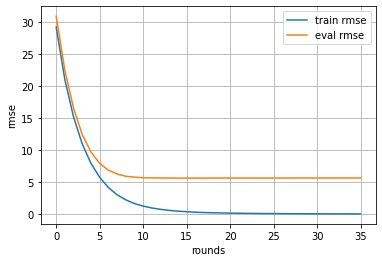

In [122]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')

eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')

plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

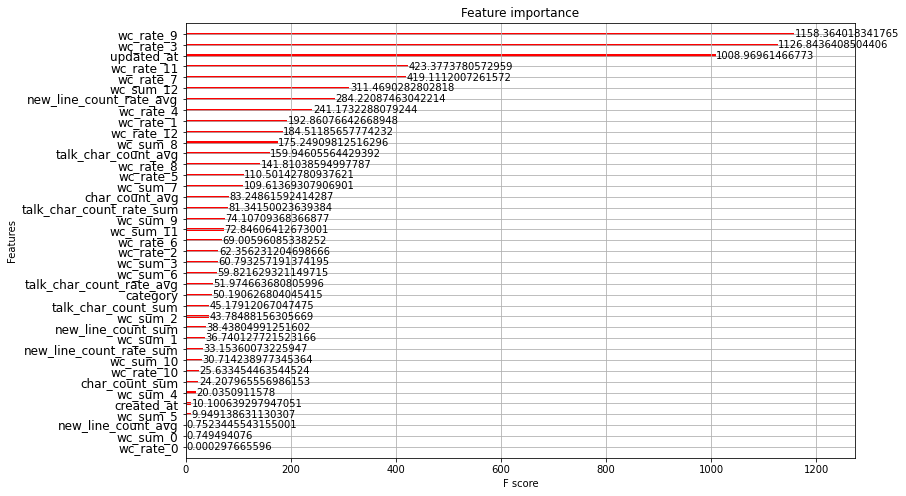

<Figure size 960x640 with 0 Axes>

In [123]:
_, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(bst,ax=ax,
                    importance_type='gain',
                    show_values=True,
                    color='red')

plt.yticks(fontsize=12)
plt.figure(dpi=160)

plt.show()

In [124]:
df_test = laod_data('ranking_test_data.csv')
print(len(df_test))
df_test.head(3)

65


,ncode,title,category,bookmark_cat,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,talk_char_count_avg,new_line_count_rate_avg,talk_char_count_rate_avg,wc_sum_その他,wc_sum_フィラー,wc_sum_副詞,wc_sum_助動詞,wc_sum_助詞,wc_sum_動詞,wc_sum_名詞,wc_sum_形容詞,wc_sum_感動詞,wc_sum_接続詞,wc_sum_接頭詞,wc_sum_記号,wc_sum_連体詞,wc_rate_その他,wc_rate_フィラー,wc_rate_副詞,wc_rate_助動詞,wc_rate_助詞,wc_rate_動詞,wc_rate_名詞,wc_rate_形容詞,wc_rate_感動詞,wc_rate_接続詞,wc_rate_接頭詞,...,kw_残酷な描写あり,kw_ギルド,kw_ハーレム,kw_人外,kw_クラス転移,kw_追放,kw_魔法,kw_学園,kw_冒険,kw_異世界転移,kw_ダンジョン,kw_魔王,kw_日常,kw_人外転生,kw_アイテム,kw_ほのぼの,kw_内政,kw_聖女,kw_ギャグ,kw_勘違い,kw_異世界,kw_スローライフ,kw_スキル,kw_書籍化,kw_異世界転生,kw_西洋,kw_ネット小説大賞,kw_剣と魔法,kw_サバイバル,kw_コミカライズ,kw_シリアス,kw_男主人公,kw_バトル,kw_もふもふ,kw_成り上がり,kw_勇者,kw_女主人公,kw_貴族,kw_乙女ゲーム,rating
0,n8642gc,聖貨を集めて、ぶん回せ！,ハイファンタジー〔ファンタジー〕,-1,1.585469e+09,1.593763e+09,37740,2310,0,0.061208,0.000000,1258.0,77.0,0.0,0.061208,0.000000,0,0,390,360,5010,3120,8040,300,0,0,0,3570,30,0.0,0.000000,0.018732,0.017291,0.240634,0.149856,0.386167,0.014409,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-1
1,n8693gg,十年目、帰還を諦めた転移者はいまさら主人公になる,ハイファンタジー〔ファンタジー〕,-1,1.591009e+09,1.593774e+09,144330,5760,44100,0.039909,0.305550,4811.0,192.0,1470.0,0.039909,0.305550,0,30,3540,7710,23310,20070,21990,1770,240,570,90,12210,780,0.0,0.000325,0.038349,0.083523,0.252519,0.217420,0.238219,0.019175,0.002600,0.006175,0.000975,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,n4452ge,俺だけレベルが上がる世界で悪徳領主になっていた,ハイファンタジー〔ファンタジー〕,-1,1.587737e+09,1.593006e+09,156720,6210,13290,0.039625,0.084801,5224.0,207.0,443.0,0.039625,0.084801,0,0,4650,8640,24120,20490,23460,1110,240,720,150,12300,1170,0.0,0.000000,0.047913,0.089026,0.248532,0.211128,0.241731,0.011437,0.002473,0.007419,0.001546,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-1


In [125]:
df_test2 = data_preprocess(df_test)
df_test2.head(3)

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,talk_char_count_avg,new_line_count_rate_avg,talk_char_count_rate_avg,wc_sum_0,wc_sum_1,wc_sum_2,wc_sum_3,wc_sum_4,wc_sum_5,wc_sum_6,wc_sum_7,wc_sum_8,wc_sum_9,wc_sum_10,wc_sum_11,wc_sum_12,wc_rate_0,wc_rate_1,wc_rate_2,wc_rate_3,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.585469e+09,1.593763e+09,37740,2310,0,0.061208,0.000000,1258.0,77.0,0.0,0.061208,0.000000,0,0,390,360,5010,3120,8040,300,0,0,0,3570,30,0.0,0.000000,0.018732,0.017291,0.240634,0.149856,0.386167,0.014409,0.000000,0.000000,0.000000,0.171470,0.001441,-10
1,6,1.591009e+09,1.593774e+09,144330,5760,44100,0.039909,0.305550,4811.0,192.0,1470.0,0.039909,0.305550,0,30,3540,7710,23310,20070,21990,1770,240,570,90,12210,780,0.0,0.000325,0.038349,0.083523,0.252519,0.217420,0.238219,0.019175,0.002600,0.006175,0.000975,0.132272,0.008450,-10
2,6,1.587737e+09,1.593006e+09,156720,6210,13290,0.039625,0.084801,5224.0,207.0,443.0,0.039625,0.084801,0,0,4650,8640,24120,20490,23460,1110,240,720,150,12300,1170,0.0,0.000000,0.047913,0.089026,0.248532,0.211128,0.241731,0.011437,0.002473,0.007419,0.001546,0.126739,0.012056,-10


In [126]:
X = df_test2.drop(['rating'], axis=1).values
y = df_test2['rating'].values
print(X.shape)

#dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X, label=y, feature_names=feature_names)
#print(dtest)

(65, 39)


In [127]:
y_pred = bst.predict(dtest)
y_pred

array([28.804386, 23.402243, 13.449044, 20.296268, 37.701756, 17.45363 ,
       11.574792, 15.590633, 31.061865, 26.297287, 16.103573, 18.898006,
       30.415628, 31.151493, 12.174487, 23.600046, 23.001102, 20.160799,
       33.741177, 19.613424,  9.030477, 17.242914, 15.018677, 34.87579 ,
       40.47919 , 20.344704, 33.336243, 21.463127, 25.751616, 16.717478,
       17.74739 , 36.607025, 24.796362,  8.836401, 27.382318, 23.233244,
       13.669072, 20.26846 , 30.65231 , 19.445625, 25.734444, 24.998362,
       33.4457  , 29.75195 , 41.65682 , 21.95427 , 16.059391, 37.805893,
       26.335745, 22.527542, 23.233038, 30.991137, 12.226926, 33.76162 ,
       30.642633, 16.427904, 20.543121, 22.414236, 24.552498, 19.700464,
       49.618893, 34.067783, 17.844522, 21.323812, 22.116053],
      dtype=float32)

In [128]:
df_rating = pd.DataFrame(columns=['ncode', 'title', 'rating'])

for i, y in enumerate(y_pred):
    row = df_test.loc[i] 
    #print('{}\t{}\t{}'.format(row.ncode, row.title, y))
    df_rating = df_rating.append({'ncode': row.ncode, 'title': row.title, 'rating': y}, ignore_index=True)

In [129]:
df_rating.head()

,ncode,title,rating
0,n8642gc,聖貨を集めて、ぶん回せ！,28.804386
1,n8693gg,十年目、帰還を諦めた転移者はいまさら主人公になる,23.402243
2,n4452ge,俺だけレベルが上がる世界で悪徳領主になっていた,13.449044
3,n8604ge,スキル「屋台」で異世界生活～食料生成スキルを手に入れたので、商会を立ち上げようと思います～,20.296268
4,n6812gh,悪徳領主の息子に転生！？ ～普通に行動しているだけなのに、周囲からちやほやされます～,37.701756


In [130]:
df_rating.describe()

,rating
count,65.000000
mean,24.171151
std,8.446044
min,8.836401
25%,17.844522
50%,23.001102
75%,30.642633
max,49.618893


In [131]:
df_rating.var()

rating    71.335665
dtype: float64

In [132]:
df_rating.median()

rating    23.001102
dtype: float64

In [133]:
pd.set_option('display.max_rows', None)

df_rating.sort_values('rating', ascending=False)

,ncode,title,rating
60,n5645ci,自分が異世界に転移するなら,49.618893
44,n9984fb,身体は児童、中身はおっさんの成り上がり冒険記,41.656818
24,n8568fy,普通職の異世界スローライフ ～チート（があるくせに小者）な薬剤師の無双（しない）物語～,40.479191
47,n9940gd,最強錬金術師の異世界珍道中,37.805893
4,n6812gh,悪徳領主の息子に転生！？ ～普通に行動しているだけなのに、周囲からちやほやされます～,37.701756
31,n4342ge,聖女に追放された転生公爵は、辺境でのんびりと畑を耕すつもりだった～来るなというのに領民が沢山...,36.607025
23,n9629ex,最弱テイマーはゴミ拾いの旅を始めました。,34.875790
61,n4344dy,世界最強の後衛 ～迷宮国の新人探索者～,34.067783
53,n5782dy,ハズレ判定から始まったチート魔術士生活,33.761620
18,n2276dz,異世界でスローライフを（願望）,33.741177
